In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Classification

Compare the disciplinary classifications between the Cultuurconnect and UniCat dataset. This is done on ISBN level to make them comparable to the whole VABB dataset (for which we do not have work-id's).

We use the following: https://seaborn.pydata.org/examples/pairgrid_dotplot.html to visualize the data.

## Import data

In [3]:
# connect with cultuurconnect database
con_cc = sqlite3.connect("cultuurconnect.db")

In [4]:
# import the classification information
classifications = pd.read_csv("all_classifications20221125.csv", index_col=0,dtype={"isbn":"str"})

# import the names of the FOS disciplines
names = pd.read_excel("FOS_names.xlsx", dtype={"Code":str})

In [7]:
# get the cultuurconnect holdings
cc_holding = pd.read_sql("""SELECT i.isbn, h.frabl, COUNT(distinct library) library_count
            FROM holding h
            JOIN isbns i ON h.frabl = i.frabl
            GROUP BY i.isbn""", con_cc)

In [8]:
cc_holding = cc_holding[["isbn","library_count"]].copy()

In [9]:
# merge the holdings with the classification information
df = classifications.merge(cc_holding, on="isbn", how="outer").rename(columns={"library_count":"cc_library_count"})

In [10]:
# connect with the unicat database
con_uc = sqlite3.connect("unicat_holdings.db")

In [11]:
# get the unicat holdings
uc_holding = pd.read_sql("""SELECT i.isbn, h.work_id, COUNT(distinct location) library_count
                        FROM holding h
                        JOIN isbn_search i ON h.work_id = i.work_id
                        GROUP BY i.isbn""", con_uc)

In [13]:
uc_holding = uc_holding[["isbn","library_count"]].copy()

In [14]:
# merge with the classification information
df = df.merge(uc_holding, on="isbn", how="outer").rename(columns={"library_count":"uc_library_count"}).copy()

In [15]:
df = df[~df.classification.isna()].copy()

### Explode the dataframe

Some publications have more than one discipline assigned to them

In [16]:
df[df.classification.str.contains(";")]

,isbn,classification,classification_source,Name,cc_library_count,uc_library_count
0,9780000000002,1.5;2.2;1.2,Cognitive classification VABB,Earth and related environmental sciences; Ele...,NaN,NaN
65,9780080449340,5.1;5.3;5.4;6.2.1,Cognitive classification VABB,Psychology and cognitive sciences; Educationa...,NaN,11.0
70,9780080450940,5.1;6.2.2;5.3;6.2.1,Cognitive classification VABB,Psychology and cognitive sciences; Literature...,NaN,9.0
73,9780080453255,5.1;6.2.2;5.3;6.2.1,Cognitive classification VABB,Psychology and cognitive sciences; Literature...,NaN,9.0
100,9780123725509,3.2;3.1;2.8;1.6,Cognitive classification VABB,Clinical medicine; Basic medicine; Environmen...,NaN,12.0
...,...,...,...,...,...,...
46543,9789993202967,5.3;6.3.2,Manual,Educational sciences; Religion,NaN,NaN
46606,9791091477024,5.1;2.1,Manual,Psychology and cognitive sciences; Civil engi...,NaN,NaN
46613,9791093095080,6.1.1;5.5;5.2,Cognitive classification VABB,History; Law; Economics and business,NaN,4.0
46615,9791093309026,6.4;6.1.1;6.1.2,Cognitive classification VABB,"Arts (arts, history of arts, performing arts,...",NaN,2.0


In [17]:
df.classification = df.classification.str.split(";")

The column 'number of disciplines' will show how many disciplines each publication is associated with

In [18]:
df["number of disciplines"] = df.classification.apply(lambda x: len(x))

In [19]:
df_expl = df.explode("classification").drop(columns="Name")

Adjust the library counts for publications assigned to multiple disciplines

In [22]:
df_expl["cc_adjusted"] = df_expl.cc_library_count/df_expl["number of disciplines"]

In [21]:
df_expl["uc_adjusted"] = df_expl.uc_library_count/df_expl["number of disciplines"]

In [23]:
# add names of fos-disciplines
df_expl = df_expl.merge(names, how="left", left_on="classification", right_on="Code").drop(columns=["Code","Level"])

In [24]:
df_expl.shape

(47749, 9)

In [25]:
df_expl.isnull().sum()

isbn                         0
classification               0
classification_source      109
cc_library_count         39487
uc_library_count         21198
number of disciplines        0
uc_adjusted              21198
cc_adjusted              39487
Name                       104
dtype: int64

## Create totals dataframe

Calculate how many publications are associated with each of the disciplines. This is done for the entire VABB dataset, for the publications in Cultuurconnect and for the publications in UniCat. Here all publications are counted fully, but an alternative could be to take into account that publications can be assigned multiple disciplines (adjusted).

In [26]:
total_classifications = pd.DataFrame(df_expl.groupby("Name").isbn.count()).sort_values(by="isbn", ascending = False).reset_index()

In [27]:
CC = df_expl[df_expl.cc_adjusted.notna()]

In [28]:
CC_classifications = pd.DataFrame(CC.groupby("Name").isbn.count()).reset_index().rename(columns = {"isbn":"CC_count"})

In [29]:
CC.shape

(8262, 9)

In [30]:
UC = df_expl[df_expl.uc_adjusted.notna()]

In [31]:
UC_classifications = pd.DataFrame(UC.groupby("Name").isbn.count()).reset_index().rename(columns= {"isbn":"UC_count"})

In [32]:
total_classifications = total_classifications.merge(CC_classifications, on="Name", how="outer").copy()

In [33]:
total_classifications = total_classifications.merge(UC_classifications, on="Name", how="outer").copy()

In [34]:
total_classifications["CC_relative"] = total_classifications.CC_count/total_classifications.isbn

In [35]:
total_classifications["UC_relative"] = total_classifications.UC_count/total_classifications.isbn

In [36]:
total_classifications.head(3)

,Name,isbn,CC_count,UC_count,CC_relative,UC_relative
0,Law,8097,1574.0,4782.0,0.194393,0.590589
1,Economics and business,4222,569.0,2148.0,0.134770,0.508764
2,Sociology,4210,607.0,2402.0,0.144181,0.570546


Many disciplines only appear in very few publications. For easier readability of the table, the cut-off is set at 300.

In [37]:
total_classifications = total_classifications[total_classifications.isbn >= 300].copy()

In [38]:
total_classifications

,Name,isbn,CC_count,UC_count,CC_relative,UC_relative
0,Law,8097,1574.0,4782.0,0.194393,0.590589
1,Economics and business,4222,569.0,2148.0,0.134770,0.508764
2,Sociology,4210,607.0,2402.0,0.144181,0.570546
3,Literature,3229,563.0,1909.0,0.174357,0.591205
4,Languages and linguistics,3178,267.0,1761.0,0.084015,0.554122
5,History,3167,745.0,2105.0,0.235238,0.664667
6,"Arts (arts, history of arts, performing arts,...",3077,960.0,1953.0,0.311992,0.634709
7,Religion,2582,344.0,1638.0,0.133230,0.634392
8,Political science,2462,403.0,1489.0,0.163688,0.604793
9,Educational sciences,2048,519.0,1011.0,0.253418,0.493652


## Visualize

In [39]:
total_classifications.head(2)

,Name,isbn,CC_count,UC_count,CC_relative,UC_relative
0,Law,8097,1574.0,4782.0,0.194393,0.590589
1,Economics and business,4222,569.0,2148.0,0.134770,0.508764


In [40]:
total_classifications.columns[1:4]

Index(['isbn', 'CC_count', 'UC_count'], dtype='object')

<Figure size 1440x720 with 0 Axes>

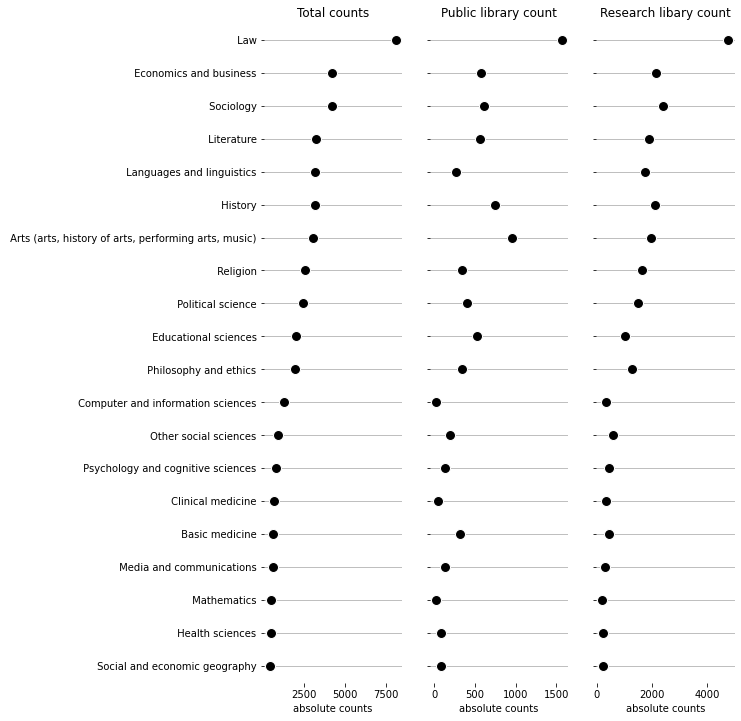

In [41]:
# visualize with the same barplot
fig=plt.figure(figsize=(20,10))

data = total_classifications.sort_values(by="isbn", ascending = False).head(20)

# make the pairgrid
g = sns.PairGrid(data.sort_values("isbn", ascending=False),
                x_vars=data.columns[1:4], y_vars=["Name"],
                height=10, aspect=0.25)

# draw a plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
     color="black", linewidth=1, edgecolor="w")

# Use same x-axis limits on all columns and add better labels
g.set(xlabel="absolute counts", ylabel="")

titles = ["Total counts", "Public library count", "Research libary count"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


plt.savefig("plots/classification_counts.png", bbox_inches="tight")
